### Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as Functions
import torch.optim as Optimizers
from torch.utils.data import Dataset

from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import os
from google.colab import drive
from PIL import Image

### Set Device


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Download Dataset, transform to Tensor and normalize

In [3]:
transform = ToTensor()
drive.mount('/content/drive')  # to access the dataset, you should make a copy of the dataset on your drive.
data_path = '/content/drive/My Drive/data'

train_smile_dir = data_path + '/train/smile'
train_non_smile_dir = data_path + '/train/non_smile'
test_dir = data_path + '/test'

def load_images_from_folder(folder, transform):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        image = Image.open(img_path)
        image = transform(image)
        images.append(image)
    return torch.stack(images)

smile = load_images_from_folder(train_smile_dir, transform)
non_smile = load_images_from_folder(train_non_smile_dir, transform)
test = load_images_from_folder(test_dir, transform)

# normalization
train = torch.cat((smile, non_smile),0)
mean = train.mean([0, 2, 3])
std = train.std([0, 2, 3])
normalize = Normalize(mean=mean, std=std)
unnormalize = Normalize((-mean / std), (1.0 / std))

train = normalize(train)
test = normalize(test)
smile = normalize(smile)
non_smile = normalize(non_smile)


Mounted at /content/drive


In [4]:
class CustomImageDataset(Dataset):  # since we have unlabeled data, we should define a custom DataSet
    def __init__(self, image_tensors):
        self.image_tensors = image_tensors

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return self.image_tensors[idx]

train_loader = DataLoader(CustomImageDataset(train), batch_size=128, shuffle=True)
test_loader = DataLoader(CustomImageDataset(test), batch_size=128, shuffle=False)

### A Brief View on Data

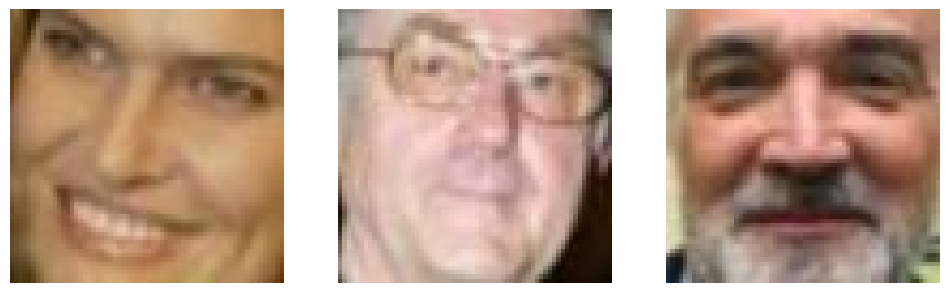

In [5]:
for sample_batch in train_loader:

    images = sample_batch[:3]
    images = unnormalize(images)
    images = images.permute(0, 2, 3, 1).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()
    break

### Define Model


In [6]:
class View(nn.Module):  # to use it in nn.Sequential
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(0.2),

            View((-1, 64 * 16 * 16)),
            nn.Linear(64 * 16 * 16, 4096),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2048, 64 * 16 * 16),
            nn.ReLU(True),
            View((-1, 64, 16, 16)),

            nn.ConvTranspose2d(64, 64, 3, stride=2, padding = 1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(64, 64, 3, stride=2, padding = 1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(64, 32, 3, stride=1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(32, 3, 3, stride=1, padding = 1),

        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterization(self, miu, log_sigma):
        sigma = torch.exp(log_sigma)  # to ensure sigma is positive
        return  sigma * torch.randn_like(sigma) + miu

    def forward(self, x):
        enc = self.encode(x)
        miu = enc[:,:2048]
        log_sigma = enc[:,2048:]
        x_recon = self.decode(self.reparameterization(miu,log_sigma))
        return x_recon, miu, log_sigma

### Create Model

In [7]:
model = Model().to(device)
model

Model(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout2d(p=0.2, inplace=False)
    (16): View()
    (17): Line


### define the Loss Function

In [9]:
def vae_loss(recon_x, x, miu, log_sigma):
    recon_loss =  Functions.mse_loss(recon_x, x, reduction = 'sum') / (64 * 64)  # Reconstruction Loss (divided by its dimension to get a mean of it)
    kl_loss = -0.5 * torch.sum(1 + log_sigma - miu.pow(2) - log_sigma.exp()) / (2048)   # KL of two normal dist (divided by its dimension to get a mean of it)
    loss =  recon_loss + kl_loss
    return loss, recon_loss, kl_loss

### Optimizer

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### Training Model
After configuring all required parameters, it is time to train your model!

In [11]:
EPOCHS = 100

train_kl  = []
test_kl = []
train_recon  = []
test_recon = []

for e in tqdm(range(EPOCHS)):
  # training
  recon_loss_acc = 0
  kl_acc = 0

  model.train()
  for x_train in train_loader:

    x_train_dev = torch.autograd.Variable(x_train).to(device)
    optimizer.zero_grad()
    x_recon, miu, log_sigma = model(x_train_dev)
    loss, recon_loss, kl = vae_loss(x_recon, x_train_dev, miu, log_sigma)

    loss.backward()
    optimizer.step()

    recon_loss_acc += recon_loss.item()
    kl_acc += kl.item()

  train_recon.append(recon_loss_acc/len(train))
  train_kl.append(kl_acc/len(train))


  # testing
  model.eval()
  for x_test in test_loader:

    x_test_dev = x_test.to(device)
    x_recon, miu, log_sigma = model(x_test_dev)
    loss, recon_loss, kl = vae_loss(x_recon, x_test_dev, miu, log_sigma)
    recon_loss_acc += recon_loss.item()
    kl_acc += kl.item()

  test_recon.append(recon_loss_acc/len(test))
  test_kl.append(kl_acc/len(test))


  0%|          | 0/100 [00:00<?, ?it/s]

### plotting model performance


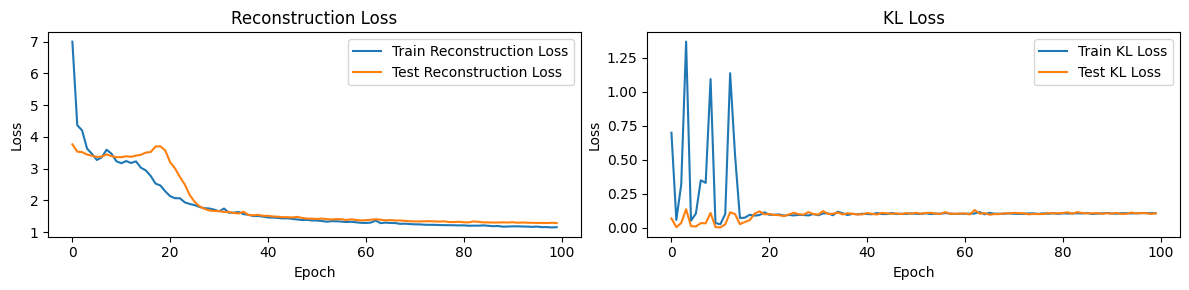

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(train_recon, label='Train Reconstruction Loss')
ax1.plot(test_recon, label='Test Reconstruction Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.set_title('Reconstruction Loss')

ax2.plot(train_kl, label='Train KL Loss')
ax2.plot(test_kl, label='Test KL Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.set_title('KL Loss')

plt.tight_layout()
plt.show()

###showing 32 pictures with their reconstruction, and their noisy reconstruction

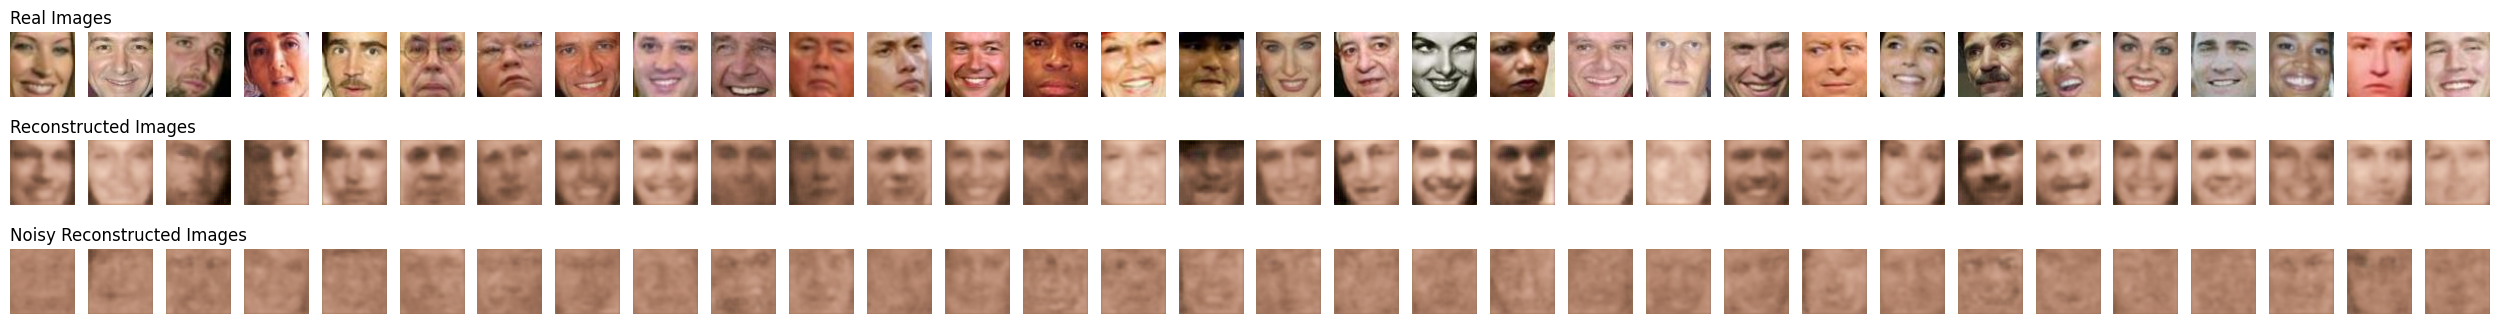

In [13]:
for sample_batch in train_loader:

    images = sample_batch[0:32].to(device)
    model.eval()

    # reconstruction
    recon,_,_ = model(images)
    # noise reconstruction
    nois_z = torch.randn((32,2048)).to(device)
    nois_recon = model.decode(nois_z)

    real_images = unnormalize(images)
    recon_images = unnormalize(recon)
    nois_recon_images = unnormalize(nois_recon)

    real_images = real_images.permute(0, 2, 3, 1).cpu().detach().numpy()
    recon_images = recon_images.permute(0, 2, 3, 1).cpu().detach().numpy()
    nois_recon_images = nois_recon_images.permute(0, 2, 3, 1).cpu().detach().numpy()

    fig, axes = plt.subplots(3, 32, figsize=(32, 4))

    axes[0, 0].set_title('Real Images', loc='left')
    axes[1, 0].set_title('Reconstructed Images', loc='left')
    axes[2, 0].set_title('Noisy Reconstructed Images', loc='left')

    for i in range(32):
        axes[0, i].imshow(real_images[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_images[i])
        axes[1, i].axis('off')
        axes[2, i].imshow(nois_recon_images[i])
        axes[2, i].axis('off')

    plt.show()
    break

### smile, non-smile

In [19]:
smile_loader = DataLoader(CustomImageDataset(smile), batch_size=128, shuffle=True)
non_smile_loader = DataLoader(CustomImageDataset(non_smile), batch_size=128, shuffle=True)

# calcualting mean of smile hidden space
z_smile = torch.zeros(2048).to(device)
model.eval()
for x_smile in smile_loader:
  x_smile = x_smile.to(device)
  enc = model.encode(x_smile)
  miu = enc[:,:2048]
  log_sigma = enc[:,2048:]
  z_smile += torch.sum(model.reparameterization(miu,log_sigma), 0) / len(smile)

# calcualting mean of non-smile hidden space
z_non_smile = torch.zeros(2048).to(device)
model.eval()
for x_non_smile in non_smile_loader:
  x_non_smile = x_non_smile.to(device)
  enc = model.encode(x_non_smile)
  miu = enc[:,:2048]
  log_sigma = enc[:,2048:]
  z_non_smile += torch.sum(model.reparameterization(miu,log_sigma), 0) / len(non_smile)

smile_vector = z_smile - z_non_smile





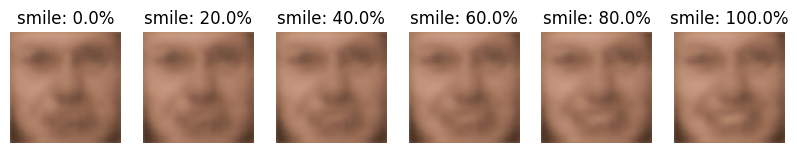

In [29]:
for x_non_smile in non_smile_loader:
  x_non_smile = x_non_smile[0].unsqueeze(0).to(device) # selecting a random non-smile image
  enc = model.encode(x_non_smile)
  miu = enc[:,:2048]
  log_sigma = enc[:,2048:]
  z = model.reparameterization(miu,log_sigma)
  fig, axes = plt.subplots(1, 6, figsize=(10, 60))

  # adding smile to the image in 6 levels
  for i in range(6):
    img = model.decode(z + i/5 * (smile_vector))
    img = unnormalize(img)
    img = img.permute(0, 2, 3, 1).cpu().detach().numpy()
    title = 'smile: ' + str(100*i/5) + '%'
    axes[i].set_title(title, loc='center')
    axes[i].imshow(img.squeeze())
    axes[i].axis('off')
  break
plt.show()